# Проект по такси в Нью-Йорке. Неделя 2

In [108]:
# Подгружаем необходимые библиотеки 
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import datetime
from mpl_toolkits.basemap import Basemap
import folium
import folium.plugins
%matplotlib inline

### Кратко воспроизводим итоги прошлой работы для получения необходимых данных

In [2]:
# Загружаем файл
data = pd.read_csv('yellow_tripdata_2016-05.csv', sep=',', usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude'])

In [3]:
# Фильтруем по расстоянию:
data = data[data.trip_distance>0]

In [4]:
# Фильтруем по числу пассажиров
data = data[data.passenger_count>0]

In [5]:
# Фильтруем по длине поездки
data = data[data.tpep_pickup_datetime < data.tpep_dropoff_datetime]

In [6]:
# Фильтруем по принадлежности  к городу 
lat_south = 40.49612
lat_north = 40.91553
long_west = -74.25559
long_east = -73.70001
data = data[(lat_south<data.pickup_latitude) & (data.pickup_latitude<lat_north) &(long_west<data.pickup_longitude)& (data.pickup_longitude<long_east)]

In [7]:
# грузим сначала информацию по регионам
regions = pd.read_csv('regions.csv', sep = ';')

In [8]:
# Определяем интервалы
bin_lat = np.unique(np.concatenate([np.unique(regions.south), np.unique(regions.north)]))
bin_long = np.unique(np.concatenate([np.unique(regions.east), np.unique(regions.west)]))

In [9]:
# Запускаем саму функцию
region_search = stats.binned_statistic_2d(data.pickup_latitude.values,data.pickup_longitude.values, None,
    'count', bins=[bin_lat, bin_long], expand_binnumbers=True)

In [10]:
# Сам регион можно получить из его групп по широте и долготе: 
data['region'] = region_search.binnumber[0]+50*region_search.binnumber[1]-50

In [11]:
# Теперь добавим столбец со временем начала поездки с точностью до часа
data['hour'] = data.tpep_pickup_datetime.apply(lambda s: datetime.datetime.strptime(s[:13], '%Y-%m-%d %H'))

In [12]:
# Далее нам потребуются только столбцы hour и region
data = data[['hour','region']]

In [13]:
# Группируем данные по часу и региону
grouped_1 = data.groupby(['hour', 'region']).size()
grouped_1.name = 'count'

In [14]:
# Сформируем список всех часов в месяце
start = datetime.datetime(2016, 5, 1)
end = datetime.datetime(2016, 6, 1)
hours = np.arange(start, end, datetime.timedelta(hours=1))

In [15]:
# Формируем сетку час - регион
product = itertools.product(hours, regions['region'].unique())
grid = pd.DataFrame(list(product))
grid.columns = ['hour', 'region']
grid.set_index(['hour', 'region'], inplace=True)

In [79]:
# Заполняем те позиции в сетке, которые отсутствуют в grouped_1 нулями
grouped = grid.join(grouped_1)
grouped.fillna(0, inplace=True)
grouped['count'] = grouped['count'].astype(int)
grouped.reset_index(inplace=True) 

### Основная часть задания

In [ ]:
# Теперь мы можем рассчитать количество регионов с нулевыми поездками, 
# а также количество регионов со средним числом поездок более 5

In [80]:
trips_by_region = grouped.groupby('region')['count'].agg({'count': np.sum})
print 'Количество  регионов c нулевыми поездками: {}'.format((trips_by_region['count'] == 0).sum())

Количество  регионов c нулевыми поездками: 1283


In [81]:
# Рассчитаем среднее число поездок и количество регионов, для которых оно больше 5
average_by_region = grouped.groupby('region')['count'].mean()
print 'Количество регионов c числом поездок не менее 5: {}'.format(average_by_region[average_by_region>=5].count())

Количество регионов c числом поездок не менее 5: 102


In [111]:
# Собираем информацию по регионам для построения карт
region_centres = []
for r in regions.index:
    region = regions.loc[r, 'region']
    mean = average_by_region[region]
    if mean >= 5:
        x = (regions.loc[r, 'west']+regions.loc[r, 'east'])/2
        y = (regions.loc[r, 'south']+regions.loc[r, 'north'])/2
        region_centres.append([y, x, mean])

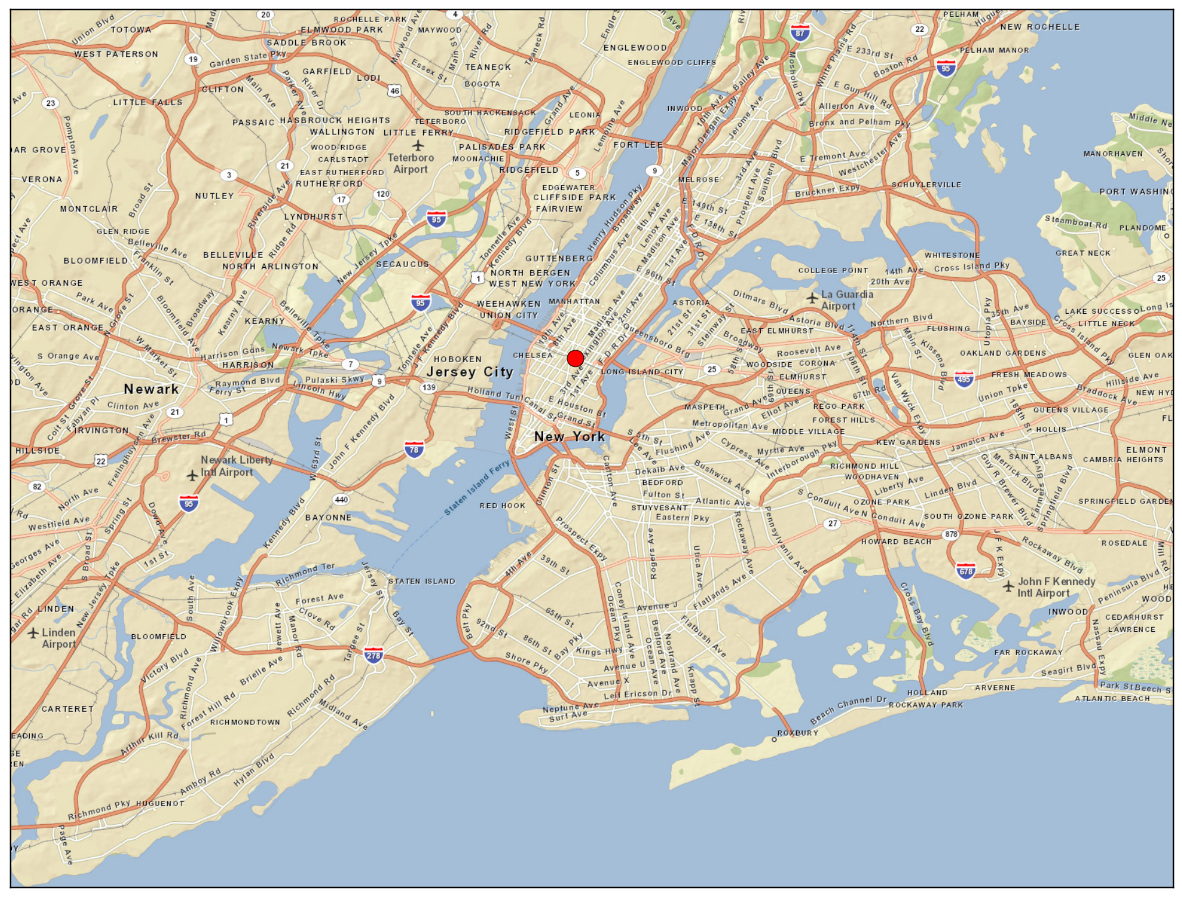

In [121]:
# Построим статическую карту с Empire State Building
esb_longitude = -73.9857012
esb_latitude = 40.7488006
plt.figure(figsize=(15, 15))
map = Basemap(llcrnrlon=long_west,llcrnrlat=lat_south,urcrnrlon=long_east,urcrnrlat=lat_north)
map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 2000)
map.plot(esb_longitude, esb_latitude, 'ok',  markersize=12, color = 'r')
plt.show()

In [118]:
# Вспомогательные расчёты для статической карты
x = np.linspace(long_west, long_east, 51)
y = np.linspace(lat_south, lat_north, 51)
x, y = np.meshgrid(x, y)
array = np.array(trips_by_region['count'].values)
z = np.reshape(array, (50, 50)).T

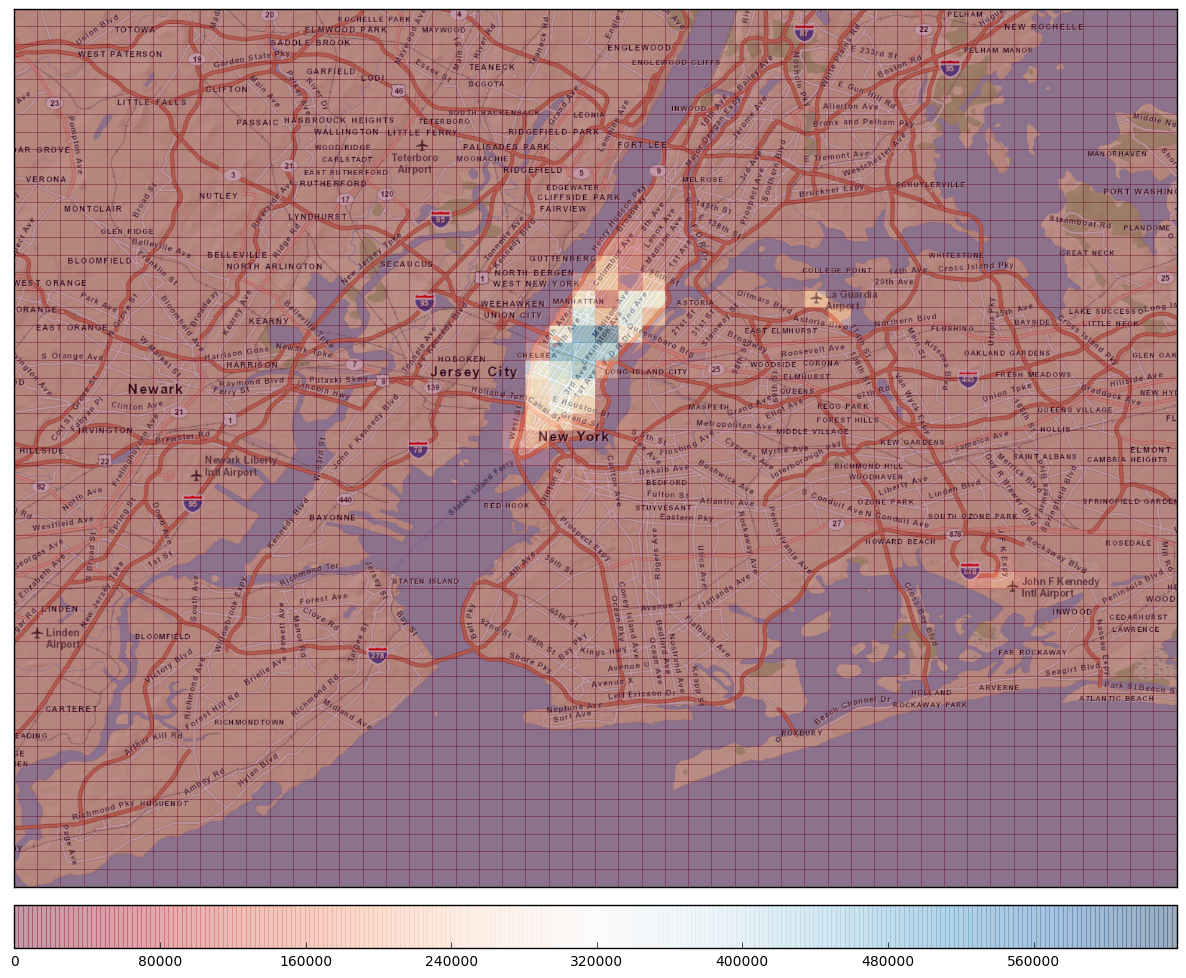

In [119]:
# Сама статическая карта с иллюстрацией числа поездок
plt.figure(figsize=(15, 15))
static_map = Basemap(llcrnrlon=long_west,llcrnrlat=lat_south,urcrnrlon=long_east,urcrnrlat=lat_north)
static_map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 2000)
pcm = static_map.pcolormesh(x, y, z,  alpha=0.4, cmap='RdBu')
static_map.colorbar(pcm, 'bottom')
plt.show()

In [39]:
# Сформируем набор вспомогательных координат
lib_lat = 40.6892494
lib_long = -74.0466891
map_centre = [(lat_south+lat_north)/float(2), (long_east+long_west)/float(2)]

In [41]:
# Интерактивная карта со статуей
interactive_map = folium.Map(location=map_centre, zoom_start=12)
folium.Marker([lib_lat, lib_long], popup='Statue of Liberty').add_to(interactive_map)
interactive_map

In [115]:
# Интерактивная карта с регионами с числом поездок по часам
interactive_map = folium.Map(location=map_centre, zoom_start=12)
folium.plugins.HeatMap(region_centres, min_opacity=0.05, radius=5, blur=5, gradient={1: 'red'}).add_to(interactive_map)
interactive_map